In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import re
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

## Enron Email Dataset
https://www.kaggle.com/wcukierski/enron-email-dataset

In [3]:
import re
import numpy as np
import pandas as pd
from datetime import datetime

from src.structures import PGraph
from src.spellcheck import find_close


def filterby_date(df, start_date=datetime(1979, 1, 1), end_date=datetime(2005, 1, 1)):
    return df[(df.datetime>=start_date)&(df.datetime<=end_date)]

node_attrs = ['name1', 'name2', 'email1', 'email2', 'org1', 'org2']
edge_bounds = ['sender', 'receiver1', 'receiver2', 'receiver3']

def infer_name(row):
    name = row['email1'].split('@')[0]
    pieces = [x for x in re.split(r'[\.\-\_]', name) if len(x)>0]
    if len(pieces)>=2 and len(pieces[0])>=2:
        return ' '.join(pieces)
    else:
        return ''
    
def infer_org(row):
    suffix = row['email1'].split('@')[-1]
    pieces = [x for x in re.split(r'\.', suffix) if len(x)>0]
    if len(pieces)==2 and pieces[0] not in ['aol', 'earthlink']:
        return pieces[0]
    elif len(pieces)>2 and pieces[-1]=='edu':
        return pieces[-2]
    else:
        return ''
    
def emails2nodes(df):
    emails = np.concatenate([df[x].unique() for x in ['sender', 'recipient1', 'recipient2', 'recipient3']])
    emails = [x for x in np.sort(np.unique(emails)) if len(x)>0]
    
    nodes = pd.DataFrame({k:['']*len(emails) if k!='email1' else emails for k in node_attrs})
    nodes['name1'] = nodes.apply(infer_name, axis=1)
    nodes['org1'] = nodes.apply(infer_org, axis=1)
    nodes = nodes.sort_values(by='org1').reset_index(drop=True)
    return nodes

def emails2edges(df, nodes):
    emails2idx = {v:k for k,v in nodes.to_dict()['email1'].items()}
    
    edges = pd.DataFrame({
        'sender':list(map(emails2idx.get, df['sender'])),
        'receiver1':list(map(emails2idx.get, df['recipient1'])),
        'receiver2':list(map(emails2idx.get, df['recipient2'])),
        'receiver3':list(map(emails2idx.get, df['recipient3'])),
        'type':['email']*len(df),
        'datetime':df['date'].tolist(),
        'desc':df['subject'].tolist(),
        'data':df['text'].tolist()
    }).fillna('')
    
    return edges

def invoices2nodes(df):
    nodes_dict = {k:[] for k in node_attrs}
    
    for i,row in df.iterrows():
        sender = row['recipient'].lower()
        recipient = row['vendor_name']
        datetime = row['date']
        desc = row['description']
        data = row['amount']

        nodes_dict['name1'].append(sender)
        nodes_dict['name2'].append('')
        nodes_dict['email1'].append('')
        nodes_dict['email2'].append('')
        nodes_dict['org1'].append('enron')
        nodes_dict['org2'].append('')
        
        nodes_dict['name1'].append('invoice')
        nodes_dict['name2'].append('')
        nodes_dict['email1'].append('')
        nodes_dict['email2'].append('')
        nodes_dict['org1'].append(recipient)
        nodes_dict['org2'].append('')
        
    return pd.DataFrame(nodes_dict).drop_duplicates().reset_index(drop=True)

def invoices2edges(df, nodes):
    receiver2idx = {v:k for k,v in nodes.to_dict()['org1'].items() if v!=''}
    sender2idx = {v:k for k,v in nodes.to_dict()['name1'].items() if v!=''}
    
    df = df[df['recipient']!='']
    
    edges = pd.DataFrame({
        'sender':list(map(sender2idx.get, df['recipient'])),
        'receiver1':list(map(receiver2idx.get, df['vendor_name'])),
        'receiver2':['']*len(df),
        'receiver3':['']*len(df),
        'type':['invoice']*len(df),
        'datetime':df['date'].tolist(),
        'desc':df['description'].tolist(),
        'data':df['amount'].tolist()
    }).fillna('')
    
    return edges

class ForensicGraph(PGraph):
    @classmethod
    def from_emails(cls, emails_path):
        emails = pd.read_csv(emails_path).fillna('')
        emails['date'] = pd.to_datetime(emails['date'])
        nodes = emails2nodes(emails)
        edges = emails2edges(emails, nodes)
        return cls(nodes=nodes, edges=edges)
    
    def __init__(self, nodes, edges):
        super().__init__(nodes, edges)
        self.add_invoices()
        
    def add_invoices(self, inv_path='data/invoices/invoices_clean.csv'):
        nodes_start, edges_start = self.nodes.index[-1]+1, self.edges.index[-1]+1
        
        invoices = pd.read_csv(inv_path).fillna('')
        invoices.date = pd.to_datetime(invoices.date)
        
        nodes = invoices2nodes(invoices)
        edges = invoices2edges(invoices, nodes)

        nodes.index+=nodes_start
        edges.index+=edges_start
        
        edges['sender']+=nodes_start
        edges['receiver1']+=nodes_start
        
        self.nodes = pd.concat([self.nodes, nodes])
        self.edges = pd.concat([self.edges, edges])
        
    def edges_from_nodes(self, *nodes, edges=None):
        if edges is None:
            return self.edges[self.edges[edge_bounds].isin(nodes).any(axis=1)]
        else:
            return edges[edges[edge_bounds].isin(nodes).any(axis=1)]
    
    def nodes_from_edges(self, *edges, nodes=None):
        if nodes is None:
            return self.nodes[self.nodes.index.isin(self.uniq_edge_values(edges, edge_bounds))]
        else:
            return nodes[nodes.index.isin(self.uniq_edge_values(edges, edge_bounds))]
        
    def make_subgraph(self, f1, f2=None, start_date=datetime(2001, 1, 1), end_date=datetime(2002, 1, 1)):
        edges = filterby_date(self.edges, start_date=start_date, end_date=end_date)
        edges = self.edges_from_nodes(*f1, edges=edges)
        
        if f2 is not None:
            edges = self.edges_from_nodes(*f2, edges=edges)
            
        nodes = self.nodes_from_edges(*edges.index)
        return PGraph(nodes=nodes, edges=edges)
        
    def _merged_row(self, *idxs):
        idxs = list(idxs)
        def pair(values):
            return values+['']*(2-len(values)) if len(values)<2 else values[:2]
            
        row = {}
        row['name1'], row['name2'] = pair(self.uniq_node_values(idxs, ['name1', 'name2']))
        row['email1'], row['email2'] = pair(self.uniq_node_values(idxs, ['email1', 'email2']))
        row['org1'], row['org2'] = pair(self.uniq_node_values(idxs, ['org1', 'org2']))
        return pd.Series(row)

    def merge(self, *idxs):
        if len(idxs)>1:
            idxs = list(sorted(idxs))
            prime, aliases = idxs[0], idxs[1:]
            merged_row = self._merged_row(*idxs)
            self.nodes.loc[prime].update(self._merged_row(*idxs))
            self.nodes = self.nodes.drop(index=aliases)

            edge_repl = dict(zip(aliases, [prime]*len(aliases))) 
            self.edges = self.edges.replace({k:edge_repl for k in edge_bounds})
            
    def search_name(self, name):
        idxs = set()
        idxs.update(find_close(name, self.nodes))
        
        pieces = [x.strip() for x in name.split() if len(x.strip())>0]
        if len(pieces)>=2:
            alt_1 = '.'.join([pieces[0][0], pieces[-1]])
            idxs.update(find_close(alt_1, self.nodes))
            
            if len(pieces)==2:
                alt_2 = '  '.join([pieces[0], pieces[1]])
                idxs.update(find_close(alt_2, self.nodes))
        return list(sorted(idxs))
    
    def search_names(self, names):
        names = [x.strip() for x in names.split(',')]
        return [self.search_name(x) for x in names]
    
    def node_summaries(self, *idxs):
        def summarize(row):
            name=row['name1']
            tag=row['email1'].split('@')[0]
            return name, row['org1'], tag
        return {idx:summarize(self.nodes.loc[idx]) for idx in idxs}

    def node_assoc(self, *idxs):
        idxs = list(sorted(idxs))
        edges = self.edges_from_nodes(*idxs).index
        nodes = self.nodes_from_edges(*edges)
        return nodes.drop(index=idxs).index.tolist()
    
    def assoc_summaries(self, *idxs):
        assoc = self.node_assoc(*idxs)
        return self.node_summaries(*assoc)

In [4]:
graph = ForensicGraph.from_emails('data/enron/emails_filtered.csv')

In [5]:
graph.edges[graph.edges.type=='email'].head()
graph.edges[graph.edges.type=='invoice'].head()

,sender,receiver1,receiver2,receiver3,type,datetime,desc,data
0,6779,1393,,,email,1979-12-31 16:00:00,Re: Update from cousins in Missouri,Letter dictated by Ken Lay Hello Janice: I enj...
1,4953,2794,,,email,1979-12-31 16:00:00,Re: Energy TF Final Report,Mr. Sikes - Kenneth L. Lay is the Chairman of ...
2,4380,9285,,,email,1979-12-31 16:00:00,"Re: BlueDog Change Order #2, Rev 4","Hi Brian, Here are my observations/questions: ..."
3,5816,4015,,,email,1979-12-31 16:00:00,Re: ERMS traders in EnPower,Enron Capital & Trade Resources Corp.
4,6439,9521,,,email,1979-12-31 16:00:00,,"George, In response to your ideas Time and cos..."


,sender,receiver1,receiver2,receiver3,type,datetime,desc,data
62566,14779,14780,,,invoice,1998-02-16,Workforce Now\nADP Flexible Spending\nAccounts...,563.63
62567,14779,14780,,,invoice,1998-03-23,ADP Workforce Now\nADP Flexible Spending\nAcco...,555.3
62568,14782,14783,,,invoice,1998-05-21,Review materials from client re alleged fraud ...,3420
62569,14784,14785,,,invoice,1998-10-19,,116.69
62570,14786,14787,,,invoice,1999-03-21,,1160.89


In [6]:
finder = graph.search_names('kenneth lay, jeff skilling')
# graph.nodes.loc[finder[0]]
# graph.nodes.loc[finder[1]]

graph.merge(*finder[0])
graph.merge(*[i for i,x in graph.nodes.loc[finder[1]].iterrows() if x.org1=='enron'])

finder = graph.search_names('kenneth lay, jeff skilling')
graph.nodes.loc[finder[0]]
graph.nodes.loc[finder[1]]

,name1,name2,email1,email2,org1,org2
4136,kenneth lay,kenneth s lay,k_lay@enron.com,kenneth.lay@enron.com,enron,


,name1,name2,email1,email2,org1,org2
3576,,,kskilling@ehshouston.org,,ehshouston,
5539,jeff skilling,jeff t skilling,jeff.skilling@enron.com,jeff_skilling@enron.com,enron,
13812,,,tskilling@tribune.com,,tribune,


In [7]:
poi = [4136]
assoc = graph.node_assoc(*poi)
orgs = [x[0] for x in Counter(graph.nodes.loc[assoc].org1).most_common()]

len(poi)
len(assoc)
len(orgs)

1

1286

505

In [8]:
stoporgs = [
    '', 'enron', 'attbi', 'excite', 'home', 'att', 'pacbell', 
    'yahoo', 'msn', 'hotmail', 'juno', 'netscape', 'webtv'
]
toporgs = [x[0] for x in Counter(graph.nodes.loc[assoc].org1).most_common() if x[0] not in stoporgs][:10]
outorgs = graph.nodes[graph.nodes['org1'].isin(toporgs)].index.tolist()
outorg_edges = graph.edges[graph.edges[edge_bounds].isin(outorgs).any(axis=1)]

len(outorgs)
len(list(sorted(
    set([int(x) for x in outorg_edges[edge_bounds].values.reshape(-1) if x!=''])
)))
len(list(sorted(
    set([int(x) for x in outorg_edges[edge_bounds].values.reshape(-1) if x!='' and int(x) not in outorgs])
)))

159

243

84

In [9]:
withoutorgs = list(sorted(
    set([int(x) for x in outorg_edges[edge_bounds].values.reshape(-1) if x!='' and int(x) not in outorgs])
))
node_something = graph.nodes.loc[withoutorgs][graph.nodes.loc[withoutorgs].org1=='enron']
node_something.tail()

,name1,name2,email1,email2,org1,org2
9546,bill rapp,,bill.rapp@enron.com,,enron,
9656,jeff dasovich,,jeff.dasovich@enron.com,,enron,
9700,benjamin rogers,,benjamin.rogers@enron.com,,enron,
14801,"rosalee fleming,",,,,enron,
14805,rosalee fleming,,,,enron,


In [10]:
neworgs = orgs[:10]
newassoc = graph.nodes.loc[assoc]
newassoc = newassoc[newassoc['org1'].isin(neworgs)].index[:]

## Graph Models

In [11]:
import random
import matplotlib.colors as mcolors

from src.nxutils import graph_to_networkx, grouped_layout

def edge_summaries(idxs, nodes, edges):
    def summarize(row):
        sender_row = nodes.loc[int(row['sender'])]
        receiver_row = nodes.loc[int(row['receiver1'])]
        sender = sender_row['name1'] if sender_row['name1'] is not '' else sender_row['email1'].split('@')[0]
        receiver = receiver_row['name1'] if receiver_row['name1'] is not 'invoice' else receiver_row['org1']
        return row['datetime'].strftime("%y/%m/%d"), sender, receiver, row['desc'][:10]
    return {idx:summarize(edges.loc[idx]) for idx in idxs}

In [12]:
subgraph = graph.make_subgraph(
        f1=poi, f2=newassoc,
        start_date=datetime(2001, 5, 1), end_date=datetime(2001, 7, 1)
    )
subgraph.nodes.head()
subgraph.edges.head()

,name1,name2,email1,email2,org1,org2
901,,,jimbrulte@aol.com,,,
903,,,jhduncan@aol.com,,,
1204,,,morrisjhd@aol.com,,,
1393,,,maxwells@train.missouri.org,,,
4136,kenneth lay,kenneth s lay,k_lay@enron.com,kenneth.lay@enron.com,enron,


,sender,receiver1,receiver2,receiver3,type,datetime,desc,data
34058,6046,4136,,,email,2001-05-01 00:38:00,Re: EGM - all company meeting,"Sorry, 3pm- 5+pm. m Kenneth Lay@ENRON on 05/01..."
34365,4434,5539,4136,,email,2001-05-02 05:20:00,Hello - From India -[Please Read],"Respected Sirs: This is Xafira Mendonsa, one o..."
36149,11902,5539,4136,5938,email,2001-05-15 02:15:00,The Sunshine Kids and Enron,Please Read the attached letter. - Enron Corp....
36293,9476,5539,4136,5938,email,2001-05-15 12:15:00,The Sunshine Kids and Enron,Please Read the attached letter. - Enron Corp....
36981,1204,4136,,,email,2001-05-21 09:26:52,TFA Follow-up letter,For your review. - TFADRA~1.DOC


In [13]:
edge_summaries([40051, 62583, 62584], subgraph.nodes, subgraph.edges)

{40051: ('01/06/21', 'betty tauzier', 'kenneth lay', 'Flood Reli'),
 62583: ('01/05/18', 'kenneth lay', 'mindspring', 'SERVICE RE'),
 62584: ('01/05/18', 'kenneth lay', 'mindspring', 'SERVICE RE')}

In [14]:
subgraph.edges[subgraph.edges.type=='invoice']

,sender,receiver1,receiver2,receiver3,type,datetime,desc,data
62583,4136,14794,,,invoice,2001-05-18,SERVICE REQUEST/AUTHORIZATION FROM JOHN LAU: L...,255.9
62584,4136,14794,,,invoice,2001-05-18,SERVICE REQUEST/AUTHORIZATION FROM JOHN LAU. L...,255.9
62587,4136,14794,,,invoice,2001-06-24,,97


In [15]:
idxs = subgraph.nodes.index.tolist()
labels = [row['name1'] if len(row['name1'])>0 else row['email1'].split('@')[0] for i,row in subgraph.nodes.iterrows()]
orgs = subgraph.nodes.org1.tolist()
G = graph_to_networkx(subgraph)

{901: '', 903: '', 1204: '', 1393: '', 4136: 'enron', 4185: 'enron', 4420: 'enron', 4434: 'enron', 5539: 'enron', 5938: 'enron', 6046: 'enron', 6168: 'enron', 6548: 'enron', 7708: 'enron', 7772: 'enron', 7963: 'enron', 8229: 'enron', 8246: 'enron', 8814: 'enron', 9420: 'enron', 9476: 'enron', 9529: 'enron', 9621: 'enron', 9770: 'enron', 11902: 'msn', 12358: 'pacbell', 14794: 'mindspring'}


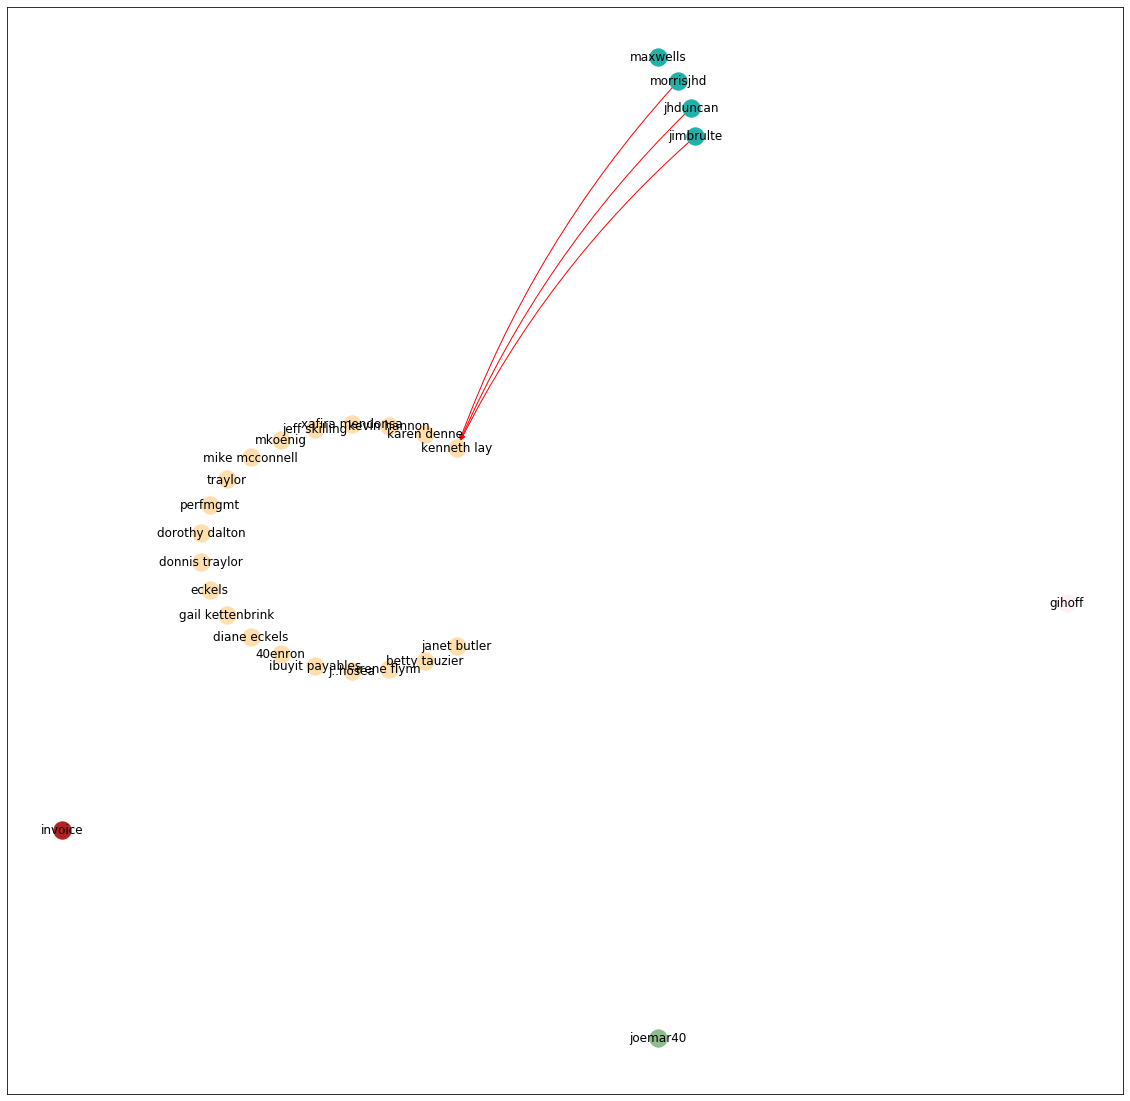

In [16]:
import numpy as np

pos, nodes_by_color = grouped_layout(G, rad=3.5)

#################################

# First draw the nodes 
plt.figure(figsize=(20,20))
for color, node_names in nodes_by_color.items():
    nx.draw_networkx_nodes(G, pos=pos, nodelist=node_names, node_color=color, label={x:G.nodes[x]['label'] for x in G.nodes})

labels={x:G.nodes[x]['label'] for x in G.nodes}
nx.draw_networkx_edges(G, pos=pos, edgelist=list(G.edges)[:3], edge_color='red', connectionstyle='arc3, rad = 0.1')
nx.draw_networkx_labels(G, pos=pos, labels=labels)
plt.show()
pass;

# Embeddings

In [17]:
import torch.nn as nn

In [30]:
import torch
import dataclasses
from dataclasses import dataclass
from typing import Any, Callable, Dict, List, Optional, Set, Tuple, Union


from transformers import (
    XLNetModel, 
    XLNetPreTrainedModel, 
    BertPreTrainedModel,
    BertModel,
    T5PreTrainedModel,
    T5Model,
    AutoConfig,
    AutoTokenizer,
)
from transformers.modeling_utils import SequenceSummary

class BertLastHidden(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.init_weights()
        
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        return outputs.last_hidden_state
    
class BERTEmbedding(nn.Module):
    def __init__(self, config):
        super(BERTEmbedding, self).__init__()
        self.hidden = BertLastHidden.from_pretrained(
            'bert-base-cased', from_tf=False, config=config, cache_dir=None
        )
        self.pooler = SequenceSummary(config)
    
    def forward(self, **kwargs):
        x = self.hidden(**kwargs)
        x = self.pooler(x)
        return x
    
class EmailDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.text = {i:row['data'] for i,row in df[df.type=='email'].iterrows()}
        self.features = {k:tokenizer(v, padding='max_length', max_length=300, truncation=True) for k,v in self.text.items()}
        self.idxs = {i:k for i,k in enumerate(self.features.keys())}

    def __len__(self):
        return len(self.features)

    def __getitem__(self, i):
        return self.features[self.idxs[i]]
    
class InvoiceDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.text = {i:row['desc'] for i,row in df[df.type=='invoice'].iterrows()}
        self.features = {k:tokenizer(v, padding='max_length', max_length=300, truncation=True) for k,v in self.text.items()}
        self.idxs = {i:k for i,k in enumerate(self.features.keys())}

    def __len__(self):
        return len(self.features)

    def __getitem__(self, i):
        return self.features[self.idxs[i]]

In [19]:
graph.edges

,sender,receiver1,receiver2,receiver3,type,datetime,desc,data
0,6779,1393,,,email,1979-12-31 16:00:00,Re: Update from cousins in Missouri,Letter dictated by Ken Lay Hello Janice: I enj...
1,4953,2794,,,email,1979-12-31 16:00:00,Re: Energy TF Final Report,Mr. Sikes - Kenneth L. Lay is the Chairman of ...
2,4380,9285,,,email,1979-12-31 16:00:00,"Re: BlueDog Change Order #2, Rev 4","Hi Brian, Here are my observations/questions: ..."
3,5816,4015,,,email,1979-12-31 16:00:00,Re: ERMS traders in EnPower,Enron Capital & Trade Resources Corp.
4,6439,9521,,,email,1979-12-31 16:00:00,,"George, In response to your ideas Time and cos..."
...,...,...,...,...,...,...,...,...
62590,4136,14802,,,invoice,2001-08-05 00:00:00,,531.66
62591,4136,14802,,,invoice,2001-08-13 00:00:00,Make up Artist,750
62592,5539,14800,,,invoice,2001-09-05 00:00:00,Software Consulting Services Rendered\n(166hrs),7138
62593,4136,14802,,,invoice,2001-09-22 00:00:00,Diabetes Video- Ozempic,1500


In [20]:
pooling_parameters = {
    "summary_activation": "tanh",
    "summary_last_dropout": 0.1,
    "summary_type": "mean",
    "summary_use_proj": True
}


tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', cache_dir=None, use_fast=True)
config = AutoConfig.from_pretrained('bert-base-cased', cache_dir=None)
config.update(pooling_parameters)
model = EmailEmbedding(config=config)
model.to('cuda')
model.eval();

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertLastHidden: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertLastHidden from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLastHidden from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
from transformers import default_data_collator

dset = EmailDataset(graph.edges, tokenizer)
dloader = torch.utils.data.DataLoader(dset, batch_size=16, collate_fn=default_data_collator)

In [22]:
from tqdm import tqdm

In [23]:
_outputs = []

for x in tqdm(dloader):
    _outputs.append(model(**{k:v.to('cuda') for k,v in x.items()}).cpu().detach())

100%|██████████| 3911/3911 [08:52<00:00,  7.34it/s]


In [24]:
outputs = torch.cat(_outputs, axis=0)

In [25]:
from src.utils import save_pickle, save_numpy

In [26]:
save_pickle(dset.idxs, 'test.pkl')
save_numpy(outputs.numpy(), 'test.npy')

In [31]:
dset2 = InvoiceDataset(graph.edges, tokenizer)
dloader2 = torch.utils.data.DataLoader(dset2, batch_size=16, collate_fn=default_data_collator)

In [32]:
_outputs2 = []

for x in tqdm(dloader2):
    _outputs2.append(model(**{k:v.to('cuda') for k,v in x.items()}).cpu().detach())

100%|██████████| 2/2 [00:00<00:00,  7.25it/s]


In [33]:
outputs2 = torch.cat(_outputs2, axis=0)
save_pickle(dset2.idxs, 'testinv.pkl')
save_numpy(outputs2.numpy(), 'testinv.npy')

In [35]:
data2 = graph.edges[graph.edges.type=='invoice'].data

In [ ]:
data

In [45]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(data2.values.reshape(-1, 1))

MinMaxScaler(feature_range=(-1, 1))

In [57]:
outputs2a = scaler.transform(data2.values.reshape(-1, 1))

In [58]:
save_numpy(outputs2a, 'testinvamt.npy')

In [77]:
def get_similarity_dict(edge_idx, idx_dict_inv, emb_arr):
    emb_query = emb_arr[idx_dict_inv[edge_idx]]
    similarities = emb_arr@emb_query.T/(np.linalg.norm(emb_arr, axis=-1)*np.linalg.norm(emb_query))
    return dict(zip(idx_dict_inv.keys(), similarities))

def get_similarity_dict2(edge_idx, idx_dict_inv, emb_arr):
    emb_query = emb_arr[idx_dict_inv[edge_idx]]
    print(emb_query)
    similarities = 1-0.5*np.abs(emb_query-emb_arr)
    return dict(zip(idx_dict_inv.keys(), similarities.squeeze()))

In [78]:
outputs2a

array([[-0.84548906],
       [-0.84779717],
       [-0.05403159],
       [-0.96932945],
       [-0.67999723],
       [-0.67999723],
       [-0.54447215],
       [-0.67999723],
       [-0.53338875],
       [-0.93433084],
       [-0.97478526],
       [-0.65451926],
       [-1.        ],
       [-0.89530341],
       [-0.91893876],
       [-0.84275423],
       [-0.79384871],
       [-0.93075644],
       [-0.93075644],
       [ 0.61097257],
       [-0.86311998],
       [-0.97478526],
       [-0.82224993],
       [ 1.        ],
       [-0.85434746],
       [-0.79384871],
       [ 0.97617068],
       [-0.58603491],
       [-0.69686894]])

In [79]:
outputs2a

array([[-0.84548906],
       [-0.84779717],
       [-0.05403159],
       [-0.96932945],
       [-0.67999723],
       [-0.67999723],
       [-0.54447215],
       [-0.67999723],
       [-0.53338875],
       [-0.93433084],
       [-0.97478526],
       [-0.65451926],
       [-1.        ],
       [-0.89530341],
       [-0.91893876],
       [-0.84275423],
       [-0.79384871],
       [-0.93075644],
       [-0.93075644],
       [ 0.61097257],
       [-0.86311998],
       [-0.97478526],
       [-0.82224993],
       [ 1.        ],
       [-0.85434746],
       [-0.79384871],
       [ 0.97617068],
       [-0.58603491],
       [-0.69686894]])

In [80]:
outputs2a[28]

array([-0.69686894])

In [81]:
{v:k for k,v in dset2.idxs.items()}[62594]

28

In [82]:
get_similarity_dict2(62594, {v:k for k,v in dset2.idxs.items()}, outputs2a)

[-0.69686894]


{62566: 0.9256899418121363,
 62567: 0.9245358825159324,
 62568: 0.6785813244666112,
 62569: 0.8637697423108894,
 62570: 0.9915641451925741,
 62571: 0.9915641451925741,
 62572: 0.9238016070933777,
 62573: 0.9915641451925741,
 62574: 0.9182599057910779,
 62575: 0.8812690495982267,
 62576: 0.8610418398448323,
 62577: 0.9788251593239125,
 62578: 0.8484344693821003,
 62579: 0.9007827653089499,
 62580: 0.8889650872817956,
 62581: 0.9270573566084788,
 62582: 0.9515101136048767,
 62583: 0.8830562482682183,
 62584: 0.8830562482682183,
 62585: 0.34607924632862286,
 62586: 0.9168744804655029,
 62587: 0.8610418398448323,
 62588: 0.9373095040177335,
 62589: 0.15156553061789957,
 62590: 0.9212607370462732,
 62591: 0.9515101136048767,
 62592: 0.16348018841784417,
 62593: 0.9445829869770019,
 62594: 1.0}

In [52]:
get_similarity_dict(3, {v:k for k,v in dset.idxs.items()}, outputs.numpy())

{0: 0.68129134,
 1: 0.88536173,
 2: 0.7953347,
 3: 1.0,
 4: 0.8220906,
 5: 0.79400694,
 6: 0.77621406,
 7: 0.7920423,
 8: 0.7948789,
 9: 0.82776326,
 10: 0.86138374,
 11: 0.8481657,
 12: 0.8405274,
 13: 0.87539726,
 14: 0.7812882,
 15: 0.8297767,
 16: 0.8012737,
 17: 0.6619316,
 18: 0.8057433,
 19: 0.805915,
 20: 0.8208768,
 21: 0.8089708,
 22: 0.83059615,
 23: 0.8065808,
 24: 0.77488774,
 25: 0.81202376,
 26: 0.78663445,
 27: 0.83565336,
 28: 0.85013086,
 29: 0.79978573,
 30: 0.7723794,
 31: 0.7937729,
 32: 0.79903275,
 33: 0.87415653,
 34: 0.80453885,
 35: 0.8598294,
 36: 0.9163102,
 37: 0.7974486,
 38: 0.84220594,
 39: 0.8020212,
 40: 0.79645306,
 41: 0.83463293,
 42: 0.8122421,
 43: 0.791094,
 44: 0.8356145,
 45: 0.79001087,
 46: 0.8042524,
 47: 0.8378378,
 48: 0.7942365,
 49: 0.84672,
 50: 0.72866505,
 51: 0.8208933,
 52: 0.6981808,
 53: 0.7951944,
 54: 0.82028425,
 55: 0.7457742,
 56: 0.7767229,
 57: 0.815408,
 58: 0.8249016,
 59: 0.7841944,
 60: 0.8223252,
 61: 0.6914958,
 62: 0

In [47]:
outputs2.numpy().shape

(29, 768)

In [48]:
scaler.transform(data2.values.reshape(-1, 1)).shape

(29, 1)

In [ ]:
tokenizer('')

In [ ]:
model(**{k:torch.tensor(v, dtype=torch.long).unsqueeze(0) for k,v in tokenizer(graph.edges.data[0]).items()}).shape

In [ ]:
tokenizer(*graph.edges.data[:5])

In [ ]:
import re

def emails_to_sentences(data):
    df_dict = {k:[] for k in data.columns}
    df_dict.pop('text')
    idx = []
    sentence = []
    
    for i, row in data.iterrows():
        sents = re.split(r'(?<=[a-z]{2})\.|\?|\!', row.text)
        n_sents = len(sents)
        for k in df_dict.keys():
            df_dict[k].extend([row[k]]+['']*(n_sents-1))
        idx.extend([i]*n_sents)
        sentence.extend(sents)
    df_dict['idx'] = idx
    df_dict['sentence'] = sentence
    return pd.DataFrame(df_dict)

In [ ]:
emails_to_sentences(data)

In [ ]:
pooling_parameters = {
    "summary_activation": "tanh",
    "summary_last_dropout": 0.1,
    "summary_type": "mean",
    "summary_use_proj": True
}

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', cache_dir=None, use_fast=True)
config = AutoConfig.from_pretrained('bert-base-cased', finetuning_task='mnli', cache_dir=None)
config.update(pooling_parameters)

embedding = BertLastHidden.from_pretrained('bert-base-cased', from_tf=False, config=config, cache_dir=None)

In [ ]:
testy = [tokenizer(x, padding='max_length', max_length=80, truncation=True) for x in data.text[:10]][0]
testy = {k:[v] for k,v in testy.items()}
testy

In [ ]:
embedding(**{k:torch.LongTensor(v).to_sparse() if k=='input_ids' else torch.LongTensor(v) for k,v in testy.items()})

In [ ]:
data

In [ ]:
[tokenizer(x, padding='max_length', max_length=80, truncation=True) for x in data.text[:10]][0]

In [ ]:
import logging
from transformers import set_seed, AutoConfig, AutoTokenizer
from transformers.trainer_utils import is_main_process
from src.nlp.glue_utils import (
    ModelArguments, 
    DataTrainingArguments, 
    TrainingArguments, 
    get_labels,
    get_label_to_id,
    GluePreprocessor, 
    AutoPreprocessor,
    ComputeMetrics
)
from datasets import DatasetDict

model_args = ModelArguments(model_name_or_path='bert-base-cased')
data_args = DataTrainingArguments(task_name='mnli', max_seq_length=80)
training_args = TrainingArguments(
    do_train=True, do_eval=True, 
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5, num_train_epochs=4.0,
    output_dir='test_bert_d768_l80',
    overwrite_output_dir=True,
    evaluation_strategy='steps',
    eval_accumulation_steps=1,
    logging_steps=500,
    eval_steps=500,
    local_rank=-1
)

set_seed(9999)

logger = logging.getLogger(__name__)
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if is_main_process(training_args.local_rank) else logging.WARN,
    )

tokenizer = AutoTokenizer.from_pretrained(
    model_args.model_name_or_path,
    cache_dir=model_args.cache_dir,
    use_fast=model_args.use_fast_tokenizer,
)

config = AutoConfig.from_pretrained(
    model_args.model_name_or_path,
    finetuning_task=data_args.task_name,
    cache_dir=model_args.cache_dir,
)

dataset_dict = DatasetDict()
dataset_dict = dataset_dict.load_from_disk('data/nli/mnli_snli_hans')

config.update(get_labels(data_args, dataset_dict))
config.update(get_label_to_id(data_args, config))
config.update({
    "summary_activation": "tanh",
    "summary_last_dropout": 0.1,
    "summary_type": "mean",
    "summary_use_proj": True
})